In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import clean as clean

In [2]:
# Load training and testing data
X_train = np.load('../train_test/X_train_balanced.npy')
y_train = np.load('../train_test/y_train_balanced.npy')
X_test = np.load('../train_test/X_test.npy')
y_test = np.load('../train_test/y_test.npy')

In [3]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
# Train the neural network model

# Define the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

def weighted_binary_crossentropy(y_true, y_pred):
    # Define weights for false negatives and false positives
    weight_for_fn = 3.0  # Increase the value to penalize false negatives more
    weight_for_fp = 1.0
    # Compute binary cross-entropy
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    # Apply weights
    weight_vector = y_true * weight_for_fn + (1 - y_true) * weight_for_fp
    return bce * weight_vector

# Define the custom metric for false negative rate
def false_negative_rate(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert probabilities to binary predictions
    fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 0)), tf.float32))
    positives = tf.reduce_sum(tf.cast(tf.equal(y_true, 1), tf.float32))
    return fn / (positives + tf.keras.backend.epsilon())  # Avoid division by zero

# Compile the model with custom metrics
model.compile(
    optimizer='adam', 
    loss=weighted_binary_crossentropy, 
    metrics=[
        'accuracy', 
        tf.keras.metrics.Recall(name='recall'), 
        false_negative_rate
    ]
)

# Train the model
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=50, batch_size=32, 
    verbose=1
)

# Evaluate the model
# Predict probabilities on the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype("int32")

Epoch 1/50


/opt/miniconda3/envs/215a/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 2s 775us/step - accuracy: 0.9207 - false_negative_rate: 15.9355 - loss: 0.4046 - recall: 0.9221 - val_accuracy: 0.9597 - val_false_negative_rate: 13.4905 - val_loss: 0.1224 - val_recall: 0.7922
Epoch 2/50
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 2s 721us/step - accuracy: 0.9851 - false_negative_rate: 15.7066 - loss: 0.1090 - recall: 0.9974 - val_accuracy: 0.9687 - val_false_negative_rate: 13.6692 - val_loss: 0.1081 - val_recall: 0.7597
Epoch 3/50
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 2s 739us/step - accuracy: 0.9898 - false_negative_rate: 15.6560 - loss: 0.0707 - recall: 0.9978 - val_accuracy: 0.9740 - val_false_negative_rate: 13.7947 - val_loss: 0.1037 - val_recall: 0.6883
Epoch 4/50
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.9932 - false_negative_rate: 15.7959 - loss: 0.0505 - recall: 0.9990 - val_accuracy: 0.9756 - val_false_negative_rate: 13.8593 - val_loss: 0.1173 - val_recall: 0.6494
Epoch 5/50
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy:

In [5]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report with precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
[[8161   93]
 [  80   74]]
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9903    0.9887    0.9895      8254
         1.0     0.4431    0.4805    0.4611       154

    accuracy                         0.9794      8408
   macro avg     0.7167    0.7346    0.7253      8408
weighted avg     0.9803    0.9794    0.9798      8408



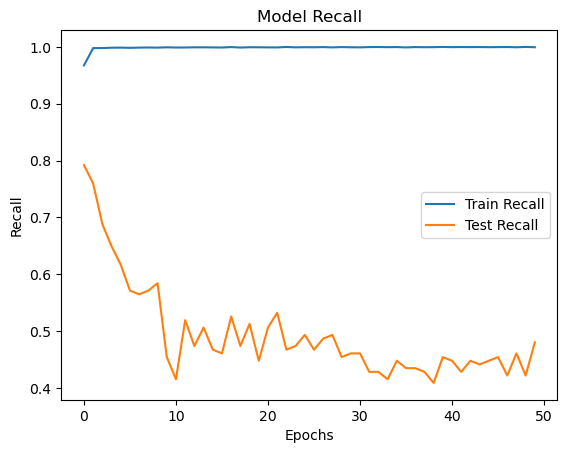

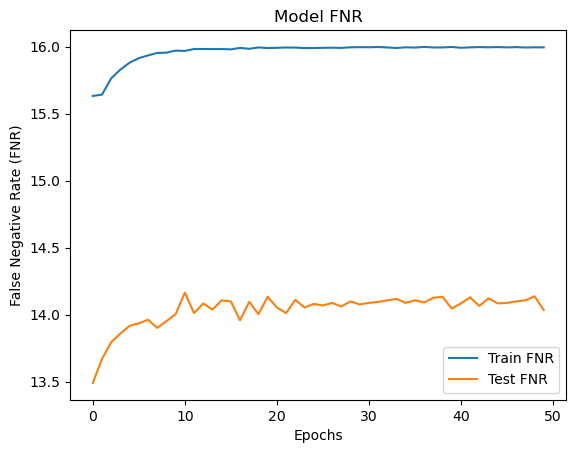

In [7]:
# Visualize training history
# Recall plot
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Test Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Model Recall')
plt.show()

# False Negative Rate plot
plt.plot(history.history['false_negative_rate'], label='Train FNR')
plt.plot(history.history['val_false_negative_rate'], label='Test FNR')
plt.xlabel('Epochs')
plt.ylabel('False Negative Rate (FNR)')
plt.legend()
plt.title('Model FNR')
plt.show()

In [10]:
# Save the probability predictions
# np.save("nn_balanced.npy", y_pred_prob)